# Humor Detection

Interpersonal communication is complex, and a common issue results from the inability of individuals to distinguish sarcasm from seriousness, as many people have the tendency to misunderstand or misinterpret the intention for humour throughout the normal course of a conversation. Creating a model that is able to accurately detect sarcasm and, in addition, identify the degree of humour / seriousness within the text, is a modern sentiment analysis problem in Natural Language Processing. Even artificially intelligent chatbots, though skilled at detecting patterns in human language, are lacking the ability to determine intent when it comes to natural language understanding. The goal of this project is to build a binary classification model that is able to classify a given text into two categories: 
- **1** = "funny text" and 
- **0** = "serious text". 

The data used in our project was obtained from Kaggle - https://www.kaggle.com/c/humor-detection/data. 
The dataset consists of two columns "text" and "label", where each row contains either a funny or serious sentence and every observation is then labeled as **1** or **0**, repectively. 

### Exploratory analysis and data preprocessing

To begin the initial examination of the dataset, it is necessary to first install and import all the packages that are needed to work with the data. Installing `pickle-mixin` allows us to retrieve pickled data with a use of `pickle.load()` function. The package called `corpy` offers a collection of handy tools for dealing with linguistic data. Its sub-package `MorphoDiTa` has pre-trained models for Czech and English, and performs morphological tagging (including lemmatization), which will be specified in more detail later. The Natural Language Toolkit `nltk` is a Python package for natural language processing and is used in our project in order to remove words that contain no meaning in a piece of text. Libraries as `wordcloud` and `matplotlib` will be used for some of the visualizations and to map the storage in which the dataset is stored, it is necessary to have the `os` package available. A built-in package called `re`, which is used to work with regular expressions, will be used to remove unneccessary characters from the text. We will use the `pandas` library to manipulate the data and `sklearn` library for the modeling part of the project. 

In [23]:
#install important packages
#!pip install pickle-mixin
#!pip install corpy
#!pip install nltk 
#!pip install wordcloud 

In [24]:
from app.utils import *

# Config

In [25]:
#load the datasets
tagger_dir = './app/Data/english-morphium-wsj-140304.tagger'
inputdata_dir ='./app/Data/data.csv'
words = list(pd.read_csv('./app/Data/stopwords.csv',header=None,index_col=None)[0]) # NLTK library stopwords also used as synonyms
stop_words =set([re.sub(r"\'",r'',word).lower() for word in words])
IsCSVInput = True

In [26]:
if IsCSVInput:
    df = pd.read_csv(inputdata_dir)
    # remove first column
    df.drop(df.columns[0], axis=1, inplace=True)
else:    
    # convert original data in pickle to prefered csv format 
    X_train_raw = open("./app/Data/X_train.pickle",'rb')
    X_train = pickle.load(X_train_raw)
    X_train_raw.close()

    y_train_raw = open("./app/Data/y_train.pickle",'rb')
    y_train = pickle.load(y_train_raw)
    y_train_raw.close()

    X_test_raw = open("./app/Data/X_test.pickle",'rb')
    X_test = pickle.load(X_test_raw)
    X_test_raw.close()

    y_test_raw = open("./app/Data/y_test.pickle",'rb')
    y_test = pickle.load(y_test_raw)
    y_test_raw.close()
    # make data ready for cross-validation 
    # we first connect them together to get better results but it's time consuming
    X=X_train+X_test
    y=y_train+y_test
    df = pd.DataFrame(list(zip(X, y)), 
                   columns =['text', 'label']) 
    df.to_csv(inputdata_dir)

Thanks to the exploratory data analysis (EDA) of the selected dataset, it is possible to collect certain information about the data. When creating a predictive model, the EDA is an essential part and the first step on the road to success. For this part, the methods of the `pandas` package were chosen, specifically `.dropna()`, dropping the rows where at least one element is missing and `.head()`, displaying the first few rows of the dataset.

In [27]:
# Drop empty values and show brief explanation
df = df.dropna()
pd.set_option('display.max_colwidth', 0)
df.head()

,text,label
0,"My grandfather died recently, He spent his final years as a regular user of facebook..We won't see the likes of him again.",1
1,I was sat in traffic the other day. Got hit by a car.,1
2,"Whats the difference between a ginger fanny and a cricket ball? If you try really hard, Really really hard, You can eat a cricket ball.",1
3,"Money can't buy happiness, but I'd much rather cry in a mansion.",1
4,2B or not 2B. That is the pencil.,1


As a part of an aggregation requirement, with the use of `.count()`, we created a bar chart showing the number of funny and serious texts. The plot below shows that the amount of serious texts in our dataset is twice the amount of funny texts. The dataset is rather imbalanced but this is the data used in the Kaggle competition, so we concluded retaining the data as unmodified is appropriate.

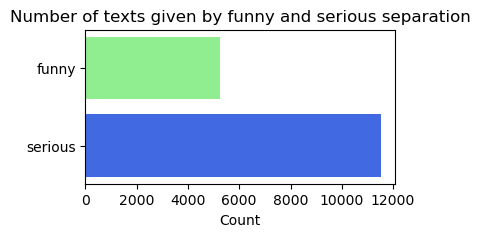

Number of funny texts is 5251
Number of serious texts is 11513


In [28]:
# Graph
from matplotlib.pyplot import figure

plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(4, 2)

# Example data
example = ["funny","serious"]
y_pos = np.arange(2)
performance = [df.loc[df['label'] == 1].count()[0],df.loc[df['label'] == 0].count()[0]]            
error = np.random.rand(2)
colors = ['lightgreen', 'royalblue'] # set the colors

ax.barh(y_pos, performance,  align='center', color = colors) # xerr=error
ax.set_yticks(y_pos)
ax.set_yticklabels(example)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Number of texts given by funny and serious separation')

plt.show()

# Print number of funny and number of serious texts
print("Number of funny texts is " + str(df.loc[df['label'] == 1].count()[0]))
print("Number of serious texts is " + str(df.loc[df['label'] == 0].count()[0]))

##### Text preprocessing

As a part of the text preprocessing, with a use of `re` library, we will get rid of characters that are not significant, such as punctuations, tags, numbers and certain special characters. The next step is converting words to their base forms using lemmatization to minimize text ambiguity. This step will convert all words having the same meaning but different representation to their base form. It reduces the word density in the given text and helps in preparing accurate features for training the machine. Simply put, after removing unneccessary characters, every element of the sentence left is tagged, changed to all lowercase letters and, if found in the set of stopwords, ommited. Tagging in `MorphoDiTa` requires supply of our own pre-trained tagging model. The tagger used was created by Charles University Faculty of Mathematics and Physics and was obtained from https://lindat.mff.cuni.cz/repository/xmlui/handle/11858/00-097C-0000-0023-68D9-0. More information about the `corpy.morphodita` sub-package can be found here: https://corpy.readthedocs.io/en/stable/guides/morphodita.html.

*Note: stop words - in NLP, useless words (data)*

##### Test tagger

In an example below we can see the way our function *preprocess()* transforms the text into an optimal form of ready-to-use words. 

In [29]:
# create tagger instance for morphodita
tagger = Tagger(tagger_dir)
tt=["My grandfather died recently, He spent his final years as a regular user of facebook."]
print("Before preprocessing : ")
print(tt)
print("")
print("After preprocessing : ")
print(preprocess(tt,stop_words,tagger))

INFO:corpy.morphodita:Loading tagger.


Before preprocessing : 
['My grandfather died recently, He spent his final years as a regular user of facebook.']

After preprocessing : 
[' grandfather die spend final year regular user facebook']


##### TF-IDF matrix and word clouds with TF-IDF

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

The computer can only understand data in the form of numerical value, so for this reason, we vectorize all of the text so that the computer can better understand the text. TF-IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a corpus.

Terminology:
- t — term (word)
- d — document (set of words)
- n — count of corpus
- corpus — the total document set

Words are represented by their term frequency multiplied by their inverse document frequency. In simpler terms, the importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 

<img src="http://3.bp.blogspot.com/-jAaRras-pOM/UXNQOMnz1BI/AAAAAAAAnYA/9FwvHPOp90c/s640/TFIDF-FIG-01.JPG" align="left" width=400 height=400>




To create tf-idf instance we used Scikit-learn's `TfidfVectorizer()`. To better illustrate the meaning behind this step, we created two WordClouds for both funny and serious text. The output clearly shows that while words such as "wife", "woman" or "joke" are very frequent in funny texts, words like "china", "work" or "child" are frequent in serious texts. 

*Note: WordCloud - the visualization technique used for representing text data in which the size of each word indicates its frequency or importance*

In [30]:
# Create tf-idf instance
tf_idf = TfidfVectorizer(min_df = 5,ngram_range=(1, 1),stop_words=stop_words)

Word cloud for funny texts:


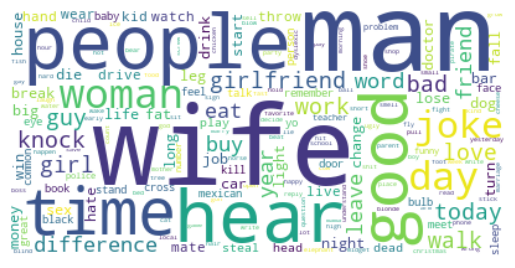

Word cloud for serious texts:


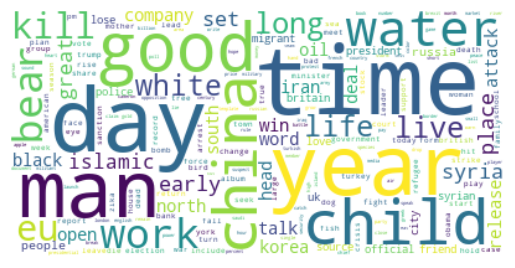

In [31]:
# Create seperated matrices for WordClouds visualizations seperately for funny and serious texts
X_fun=df["text"].loc[df['label'] == 1]
X_ser=df["text"].loc[df['label'] == 0]

print("Word cloud for funny texts:")
wordCloud(X_fun,stop_words,tagger,tf_idf)
print("Word cloud for serious texts:")
wordCloud(X_ser,stop_words,tagger,tf_idf)

## Main code 

Now let’s transform the whole dataset into tf-idf matrix. Before the classification itself, it is first necessary to determine the target variable `y_pre` and the explanatory variables `X_tf_idf`. All explanatory variables need to be numerical.

In [32]:
#Text preprocessing 
X_pre=preprocess(df["text"],stop_words,tagger)

# Trasform data to tf-idf matrix
X_tf_idf= transporttoTfIdf(X_pre,tf_idf)

# Set data as an array
y_pre= np.array(df["label"])

y_pre = y_pre.astype(int)                       #target variable
X_tf_idf = X_tf_idf.astype(float)               #explanatory variable 

A common way to get data for classifiers is to split the available data into two sets: a training set and a test set. The classification model is built on the training set and is applied to the test set. The test set has never been seen by the model so the resulting performance will be a good guide to what will be seen when the model is applied to unseen data. Very often, the proportion chosen is 70% for the training set and 30% for the test. The rationale for the higher proportion of training data is that more training data can improve the accuracy of the classification model, while more test data makes the error estimate more accurate.

The function `train_test_split()` accepts `x = X_tf_idf` and `y = y_pre`. It also takes `test_size = 0.3`, which determines the size of the test set. This function returns a list with four arrays:

- X_train: the part of x used to fit the model
- X_test: the part of x used to evaluate the model
- y_train: the part of y that corresponds to X_train
- y_test: the part of y that corresponds to X_test.

We can get different results when running the same algorithm with the same data due to the evaluation procedure. A train-test split involves randomly assigning rows to either be used to train the model or evaluate the model to meet a predefined train or test set size. Getting the same results when running the same code repeatedly can be achieved by fixing the seed for the pseudo-random number generator used when splitting the dataset - by setting the `random_state` to any integer value. 

Secondly, as our original dataset is a bit imbalanced, it is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset. This is called a stratified train-test split. We can achieve this by setting the `stratify` argument to the `y` component of the original dataset. This will be used by the `train_test_split()` function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided `y` array. 

Running the following code first reports the composition of the dataset by class label, showing the expected 11513 (class "0") vs. 5251 (class = "1") observations. Then the dataset is split and the composition of the train and test sets is reported. We can see that the train set has 8059/3675 observations and the test set has 3454/1576 observations.

In [33]:
# Split dataset into train and test sets with stratification in 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf, y_pre, test_size = 0.3, random_state=1, stratify=y_pre)
print(Counter(y_pre))
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 11513, 1: 5251})
Counter({0: 8059, 1: 3675})
Counter({0: 3454, 1: 1576})


Classification is an area of supervised machine learning that tries to predict which class or category some entity belongs to, based on its features. In our binary classification problem there are exactly two classes to choose between (0 and 1). In the following step we will evaluate and compare two algorithms that belong to a group of "supervised ML" algorithms:

- logistic regression and 
- random forest. 

We will use a pipeline to run both simultaneously. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. The following code’s `param_grid` specifies that two grids should be explored: one with a `Logistic Regression Classifier` and the second one with `Random Forest Classifier`. If we were not limited by the restricted runtime of the project, we would expand on our selection of parameters to explore. Eventually, we plug the pipe into `GridSearchCV()` to evaluate all combinations we defined and then pass our training set to the `fit` method. 

In [34]:
# Create first pipeline for base without reducing features.
LR = LogisticRegression()
RF = RandomForestClassifier()

pipe = Pipeline([('classifier', LR)])

# Create param grid.
param_grid = [
    {'classifier' : [LR],  # Logistic Regression Clasifier
     'classifier__penalty' : ['l2', 'l1']},
    {'classifier' : [RF], # Random Forest Clasifier
     'classifier__n_estimators' : [5, 10]}
]

# Create grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   18.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   20.0s finished


## Results

The next few lines of the code evaluates  which model is best.

In [35]:
Best_model_parm=best_clf.best_estimator_.get_params()['classifier']
print("Best performing model : " + str(Best_model_parm))

Best performing model : LogisticRegression()


<b>The best performing model by input parameters: Logistic regression</b>
- $p(y = 1|x) = \sigma(w^{T}x)$
- Linear classification model
- Can handle sparse data
- Fast to train, well not always :)
- Weights can be interpreted

<img src="https://i.imgur.com/VieM41f.png" align="center" width=500 height=500>

Model accuracy shown below is the most common evaluation metric for classification problems. Model accuracy on test set is almost 86% and presents the percentage of correct predictions for the test data. Let's observe another evaluation approaches. 

In [36]:
# Predict labels
print('Model accuracy on train set is',best_clf.score(X_train, y_train))
print('Model accuracy on test set is',best_clf.score(X_test, y_test))

Model accuracy on train set is 0.9009715357081984
Model accuracy on test set is 0.8570576540755467


##### Confusion matrix

A confusion matrix is used to describe the performance of a classification model on a set of test data (only explanatory variables) for which the true values are known. Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. In the output, 3294 and 1016 are correct predictions, and 560 and 160 are incorrect predictions.

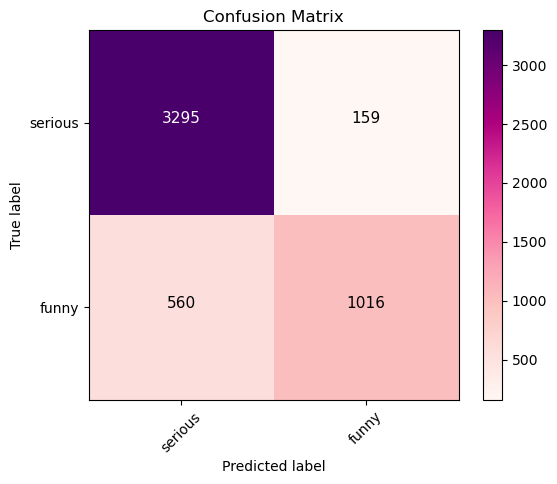

In [37]:
y_predicted=best_clf.predict(X_test)

matrix = confusion_matrix(y_test, y_predicted)
lab=["serious","funny"]
lab1=np.array(lab)

#plt.figure().set_size_inches(5, 5)
plot_confusion_matrix(matrix, classes=lab1,title='Confusion Matrix')

##### ROC vs Precision-Recall Curve

- ROC curves are appropriate when the observations are balanced between each class, whereas 
- precision-recall curves are appropriate for imbalanced datasets.

**ROC Curve** - a receiver operating characteristic curve is used for visual comparison of classification model which shows the trade-off between the true positive rate and the false positive rate. The area under the ROC curve is a measure of the accuracy of the model. An AUC (Area Under Curve) score is 0.93, which means there is 93% chance that model will be able to distinguish between funny serious and serious words. AUC score 1 represents perfect classifier, and 0.5 means model has no class separation capacity whatsoever. The ROC AUC score = 93% can be unreliable for imbalanced classification, so that is why a Precision-Recall AUC score will be examined in the following part.

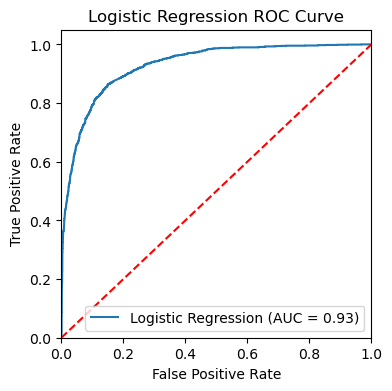

In [38]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure().set_size_inches(4, 4)
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**Precision-Recall Curve**  

Two other metrics that are often used to quantify model performance are precision and recall. Precision-recall curves also displays how well a model can classify binary outcomes. When looking at the "precision" column in a table below, we can see that 95% of the predictions for the "0" class are actually of the predicted class, and 5% are actually of the "1" class. Conversely 64% of the predictions for "1" class are actually of the predicted class, and 36% are actually of the "0" class. Recall is one of the most used evaluation metrics for an unbalanced dataset. It calculates how many of the actual positives our model predicted as positives (True Positive). This means that our model is correctly identifying 85% of the class "0" and 86% of the class "1". The recall came out very similar to the accuracy. Overall, we can say the model is relatively accurate. The-F1 score is the harmonic mean of the precision and recall.

In [39]:
print(metrics.classification_report(y_predicted, y_test))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90      3855
           1       0.64      0.86      0.74      1175

    accuracy                           0.86      5030
   macro avg       0.80      0.86      0.82      5030
weighted avg       0.88      0.86      0.86      5030



The precision-recall curve shows the tradeoff between precision and recall. Typically, a model that produces a precision-recall curve that is closer to the top-right corner is better than a model that produces a precision-recall curve that is skewed towards the bottom of the plot. The Precision-Recall AUC score is 87%. 

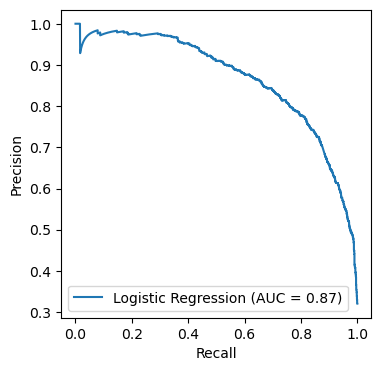

In [40]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
plt.figure().set_size_inches(4, 4)
# calculate model precision-recall curve
precision, recall, threshold = precision_recall_curve(y_test, preds)
auc_score = metrics.auc(recall, precision)
# plot the model precision-recall curve
plt.plot(recall, precision, label='Logistic Regression (AUC = %0.2f)' % auc_score)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

##### Try our model with a sentence of your choice to see whether your sentence is funny or serious with threshold level of 0.5

In [41]:
#Text preprocessing 
text=["This assignment has been created by Peter Vajdecka!",
      "What kind of sweets do astronaut moms like? Mars bars.",
      "I got almost pregnant by finishing this python assignment!",
      "I got pregnant a year after first son was born."]
sample=preprocess(text,stop_words,tagger)
sample_tranfered=tf_idf.transform(sample)
sample_tranfered = pd.DataFrame(sample_tranfered.toarray()).astype(float)
sample_tranfered.columns=tf_idf.get_feature_names()
probs = best_clf.predict_proba(sample_tranfered)
preds = probs[:,1]
labels=best_clf.predict(sample_tranfered)

print("Here you can try your own sentences (not from the corpus) to see whether your sentence is classied as funny or serious")
data = {'text': text,
        'probability':preds,
        'funny-1/serious-0':labels
        }

df_samples = pd.DataFrame(data)
pd.set_option('display.max_colwidth', 0)
display(df_samples)

Here you can try your own sentences (not from the corpus) to see whether your sentence is classied as funny or serious


,text,probability,funny-1/serious-0
0,This assignment has been created by Peter Vajdecka!,0.271728,0
1,What kind of sweets do astronaut moms like? Mars bars.,0.677515,1
2,I got almost pregnant by finishing this python assignment!,0.685258,1
3,I got pregnant a year after first son was born.,0.238186,0


##### Conclusion

The goal of our project has been successfuly fullfilled, as we managed to build an optimal classification model that is able to predict the level of seriousness within text. Our model proved to be relatively accurate and its relevance was demonstrated through the model’s ability to classify random set of sentences, yielded a high frequency of success.

# Save models for production 

In [42]:
joblib.dump(best_clf, "./app/Models/logistic_regression.joblib", compress=True)
joblib.dump(tf_idf, "./app/Models/tf_idf.joblib", compress=True)

['./app/Models/tf_idf.joblib']